# Tacotron 2 Training

This notebook is designed to provide a guide on how to train Tacotron2 as part of the TTS pipeline. It contains the following sections

  1. Tacotron2 and NeMo - An introduction to the Tacotron2 model
  2. LJSpeech - How to train Tacotron2 on LJSpeech
  3. Custom Datasets - How to collect audio data to train Tacotron2 for difference voices and languages

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [ ]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'main'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[tts]

# Tacotron2 and NeMo

Tacotron2 is a neural network that converts text characters into a mel spectrogram. For more details on the model, please refer to Nvidia's [Tacotron2 Model Card](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_tacotron2), or the original [paper](https://arxiv.org/abs/1712.05884).

Tacotron2 like most NeMo models are defined as a LightningModule, allowing for easy training via PyTorch Lightning, and parameterized by a configuration, currently defined via a yaml file and loading using Hydra.

Let's take a look using NeMo's pretrained model and how to use it to generate spectrograms.

In [1]:
# Load the Tacotron2Model
from nemo.collections.tts.models import Tacotron2Model
from nemo.collections.tts.models.base import SpectrogramGenerator

# Let's see what pretrained models are available
print(Tacotron2Model.list_available_models())

NOTE! Installing ujson may make loading annotations faster.
[PretrainedModelInfo(
	pretrained_model_name=tts_en_tacotron2,
	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo,
	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
)]


################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
# We can load the pre-trained model as follows
model = Tacotron2Model.from_pretrained("tts_en_tacotron2")

[NeMo I 2022-01-26 07:19:44 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo to /root/.cache/torch/NeMo/NeMo_1.5.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo
100% [......................................................................] 105207119 / 105207119[NeMo I 2022-01-26 07:19:47 common:728] Instantiating model from pre-trained checkpoint


[NeMo W 2022-01-26 07:19:49 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      load_audio: true
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-01-26 07:19:49 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_

[NeMo I 2022-01-26 07:19:49 features:265] PADDING: 16
[NeMo I 2022-01-26 07:19:49 features:282] STFT using torch
[NeMo I 2022-01-26 07:19:53 save_restore_connector:149] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.5.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.


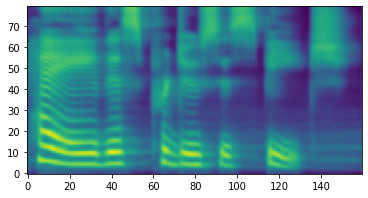

In [3]:
# Tacotron2 is a SpectrogramGenerator
assert isinstance(model, SpectrogramGenerator)

# SpectrogramGenerators in NeMo have two helper functions:
#   1. parse(str_input: str, **kwargs) which takes an English string and produces a token tensor
#   2. generate_spectrogram(tokens: 'torch.tensor', **kwargs) which takes the token tensor and generates a spectrogram
# Let's try it out
tokens = model.parse(str_input = "Hey, this produces speech!")
spectrogram = model.generate_spectrogram(tokens = tokens)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the TTS Inference notebook on how to convert spectrograms to speech.
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

# Training

Now that we looked at the Tacotron2 model, let's see how to train a Tacotron2 Model



In [ ]:
# NeMo's training scripts are stored inside the examples/ folder. Let's grab the tacotron2.py file
# as well as the tacotron2.yaml file
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/tacotron2.py
!mkdir conf && cd conf && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/tacotron2.yaml && cd ..

Let's take a look at the tacotron2.py file

```python
import pytorch_lightning as pl

from nemo.collections.common.callbacks import LogEpochTimeCallback
from nemo.collections.tts.models import Tacotron2Model
from nemo.core.config import hydra_runner
from nemo.utils.exp_manager import exp_manager


# hydra_runner is a thin NeMo wrapper around Hydra
# It looks for a config named tacotron2.yaml inside the conf folder
# Hydra parses the yaml and returns it as a Omegaconf DictConfig
@hydra_runner(config_path="conf", config_name="tacotron2")
def main(cfg):
    # Define the Lightning trainer
    trainer = pl.Trainer(**cfg.trainer)
    # exp_manager is a NeMo construct that helps with logging and checkpointing
    exp_manager(trainer, cfg.get("exp_manager", None))
    # Define the Tacotron 2 model, this will construct the model as well as
    # define the training and validation dataloaders
    model = Tacotron2Model(cfg=cfg.model, trainer=trainer)
    # Let's add a few more callbacks
    lr_logger = pl.callbacks.LearningRateMonitor()
    epoch_time_logger = LogEpochTimeCallback()
    trainer.callbacks.extend([lr_logger, epoch_time_logger])
    # Call lightning trainer's fit() to train the model
    trainer.fit(model)


if __name__ == '__main__':
    main()  # noqa pylint: disable=no-value-for-parameter
```

Let's take a look at the yaml config

```yaml
name: &name Tacotron2
sample_rate: &sr 22050
# <PAD>, <BOS>, <EOS> will be added by the tacotron2.py script
labels: &labels [' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
                 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']',
                 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                 'u', 'v', 'w', 'x', 'y', 'z']
n_fft: &n_fft 1024
n_mels: &n_mels 80
fmax: &fmax null
n_stride: &n_window_stride 256
pad_value: &pad_value -11.52
train_dataset: ???
validation_datasets: ???
```

The first part of the yaml defines some parameters used by Tacotron. You can see
that the sample rate is set to 22050 for LJSpeech. You can also see that this
model has characters for labels instead of phones. To use phones as input,
see the GlowTTS yaml and setup for an example.

Looking at the yaml, there is `train_dataset: ???` and `validation_datasets: ???`. The ??? indicates to hydra that these values must be passed via the command line or the script will fail.

Looking further down the yaml, we get to the pytorch lightning trainer parameters.

```yaml
trainer:
  gpus: 1 # number of gpus
  max_epochs: ???
  num_nodes: 1
  accelerator: ddp
  accumulate_grad_batches: 1
  checkpoint_callback: False  # Provided by exp_manager
  logger: False  # Provided by exp_manager
  gradient_clip_val: 1.0
  flush_logs_every_n_steps: 1000
  log_every_n_steps: 200
  check_val_every_n_epoch: 25
```

These values can be changed either by editing the yaml or through the command line.

Let's grab some simple audio data and test Tacotron2.

In [ ]:
!wget https://github.com/NVIDIA/NeMo/releases/download/v0.11.0/test_data.tar.gz && mkdir -p tests/data && tar xzf test_data.tar.gz -C tests/data

# Just like ASR, the Tacotron2 require .json files to define the training and validation data.
!cat tests/data/asr/an4_val.json

# Now that we have some sample data, we can try training Tacotron 2
# NOTE: The sample data is not enough data to properly train a Tacotron 2. This will not result in a trained Tacotron 2 and is used to illustrate how to train Tacotron 2 model
!python tacotron2.py sample_rate=16000 train_dataset=tests/data/asr/an4_train.json validation_datasets=tests/data/asr/an4_val.json trainer.max_epochs=3 trainer.accelerator=null trainer.check_val_every_n_epoch=1

# Training Data

In order to train Tacotron2, it is highly recommended to obtain high quality speech data with the following properties:
  - Sampling rate of 22050Hz or higher
  - Single speaker
  - Speech should contain a variety of speech phonemes
  - Audio split into segments of 1-10 seconds
  - Audio segments should not have silence at the beginning and end
  - Audio segments should not contain long silences inside

After obtaining the speech data and splitting into training, validation, and test sections, it is required to construct .json files to tell NeMo where to find these audio files.

The .json files should adhere to the format required by the `nemo.collections.asr.data.audio_to_text.AudioToCharDataset` class. For example, here is a sample .json file

```json
{"audio_filepath": "/path/to/audio1.wav", "text": "the transcription", "duration": 0.82}
{"audio_filepath": "/path/to/audio2.wav", "text": "the other transcription", "duration": 2.1}
...
```
Please note that the duration is in seconds.

Lastly, update the labels inside the Tacotron 2 yaml config if your data contains a different set of characters.

Then you are ready to run your training script:
```bash
python tacotron2.py train_dataset=YOUR_TRAIN.json validation_datasets=YOUR_VAL.json trainer.gpus=-1
```